# Introduction to Computational Science: Assignment 2
# Stochastic and Spatial Models
## Boyan Mihaylov & Sai Vinay Vardhan Daliparthi

This notebook documents the code used for the experiments conducted for Assignment 2 of the course "Introduction to Computational Science".

### 0. Prerequisites

The relevant libraries are imported below:

In [64]:
import math
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The Fourth-order Runge-Kutta method will be implemented as default numerical integration scheme for the deterministic SIR variants:

In [65]:
def runge_kutta(fun, x, step):
        """Fourth order Runge-Kutta method
        """
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

### 1. Implementation of Gillespie's Algorithm

### 1.1. Deterministic benchmark
First, we recall the procedures used for the deterministic SIR model with demography and implement them here as a Python class.

As a refresher, the characteristic ODEs for this system are:

$$
\frac{dS}{dt}=\mu-\beta S I - \mu S \\
\frac{dI}{dt}=\beta S I - \gamma I - \mu I \\
\frac{dR}{dt}=\gamma I - \mu R
$$

The parameters $\beta$, $\gamma$ and $\mu$ can be supplied during class initialization directly, or calculated in the following way:

$\beta = -\kappa ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection (in days).

$\mu = 1/L$, where $L$ is the expected lifespan of an individual (in years).

In [66]:
class InfectionModelDeterministic:
    """Basic class for the deterministic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta, gamma and mu parameters can be provided directly
        or calculated via the parameters k, c, pinf and lifespan.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta and gamma depending on inputs
        if beta:
            self.beta=beta
        else:
            self.beta = -k*math.log(1-c)
        if gamma:
            self.gamma = gamma
        else:
            self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N

        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.R0 = self.beta/(self.gamma+self.mu)
        self.ode = self.SIR_d
    

    def SIR_d(self, sir):
        """Adds ODEs for demography model
        """
        
        self.dS = self.mu - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.gamma*self.I - self.mu*self.I
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])
    
    
    def iterate(self, step, max_time, beta=None, gamma=None, constrain=True):
        """Numerical integration of the population fractions
        """
        
        # Assign native beta and gamma unless overriden
        if beta: self.beta = beta
        else: beta = self.beta
        if gamma: self.gamma = gamma
        else: gamma = self.gamma
        
        X_track = []
        Y_track = []
        Z_track = []
        N_track = []
        time_track = []
        
        time_elapsed = 0
        while time_elapsed < max_time:
            
            # Constrain to range 0 to 1
            if constrain:
                if self.S < 0: self.S = 0
                elif self.S > 1: self.S = 1
                if self.I < 0: self.I = 0
                elif self.I > 1: self.I = 1
                if self.R < 0: self.R = 0
                elif self.R > 1: self.R = 1
            
            X_track.append(self.S*self.N)
            Y_track.append(self.I*self.N)
            Z_track.append(self.R*self.N)
            time_track.append(time_elapsed)
            self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
            
            time_elapsed += step

        return time_track, X_track, Y_track, Z_track

### 1.2. Stochastic SIR

Next a new type of infection model class is constructed which implements Gillespie's Direct Algorithm.

The basic rate parameters $\beta$, $\gamma$ and $\mu$ are defined and stored in the same way as in the deterministic model. The population compartments will no more be represented by the fractions $S$, $I$ and $R$ but rather by the absolute numbers of individuals $X$, $Y$ and $Z$.

The possible events for the stochastic choice are listed in a dictionary together with their corresponding rates. Whenever a specific event is chosen for the current algorithm iteration, a designated procedure is conducted which updates the corresponding population department based on the type of event (as indicated by the selected dictionary key).

Gillespie's Direct Algorithm comprises the following steps:
- all possible events are labeled (in this case via the dictionary keys `'birth'`, `'transmission'`, `'recovery'`, `'deathX'`, `'deathY'`, `'deathZ'`);
- their rates are determined by the corresponding terms from the ODE's and stored as values in the dictionary; these rates are put in a defined order;
- the sum-total $R_T$ of all event rates is calculated;
- at each time-step in the process a random number $r_1$ from a uniform distribution is generated;
- the time until the next event is calculated as $\delta t = -\frac{1}{R_T}ln(r_1)$;
- a new random number $r_2$ is generated from a uniform distribution and multiplied with the total of the rates so that $P=r_2 R_T$;
- if $P$ falls between the values of two accumulated rates up to event $p$ ($\sum_{m=1}^{p-1}R_m < P < \sum_{m=1}^{p}R_m$), then the key for this event is chosen for the event execution and the time is updated with the step $\delta t$.

As a means to control the level of noise, the parameter `noise_lvl` is introduced which enables a probabilistic switch between a more regular sequence of events - defined as a periodically repeating series of numbers - and the uniformly distributed random numbers. The higher the noise parameter is set, the higher the probability for the random component to be selected. The periodic, quasi-deterministic pattern can be shifted at every run by a randomly set phase offset in order to precondition a smoothing of the stepped artifacts that may occur due to the sawtooth-shaped modulation. The range of the random phase offset is determined by the parameter `phase_range`.

In [97]:
class InfectionModelStochastic:
    """Basic class for the stochastic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta and gamma parameters can be provided directly
        or calculated via the parameters k, c and pinf.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta, gamma and mu depending on inputs
        if beta: self.beta=beta
        else: self.beta = -k*math.log(1-c)

        if gamma: self.gamma = gamma
        else: self.gamma = 1/pinf

        if mu: self.mu = mu
        else: self.mu = 1/lifespan
        
        # Assign population numbers
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = X+Y+Z
        
        # Calculate R0
        self.R0 = self.beta/(self.gamma+self.mu)

        # Define possible events and their starting rates
        self.events = {
            'birth': self.mu*self.N,
            'transmission': self.beta*self.X*self.Y/self.N,
            'recovery': self.gamma*self.Y,
            'deathX': self.mu*self.X,
            'deathY': self.mu*self.Y,
            'deathZ': self.mu*self.Z
        }
        
        # Assign iteration scheme
        self.iter_scheme = self.iteration_GDA
    

    def update_rates(self):
        """Updates different event rates based on current population sizes.
        """

        self.events['birth'] = self.mu*self.N
        self.events['transmission'] = self.beta*self.X*self.Y/self.N
        self.events['recovery'] = self.gamma*self.Y
        self.events['deathX'] = self.mu*self.X
        self.events['deathY'] = self.mu*self.Y
        self.events['deathZ'] = self.mu*self.Z
    

    def update_population(self, event_key):
        """Updates compartment numbers based on selected event
        """

        if event_key == 'birth':
             self.X += 1
        elif event_key == 'transmission' and self.X > 0:
            self.X -= 1
            self.Y += 1
        elif event_key == 'recovery' and self.Y > 0:
            self.Y -= 1  
            self.Z += 1     
        elif event_key == 'deathX' and self.X > 0:
            self.X -= 1
        elif event_key == 'deathY' and self.Y > 0:
            self.Y -= 1
        elif event_key == 'deathZ' and self.Z > 0:
            self.Z -= 1
        
        self.N = self.X + self.Y + self.Z

        self.update_rates()


    def iteration_GDA(self, iter_ct, phase_offset, noise_lvl=1.0):
        """Performs a single event iteration of Gillespie's Direct Algorithm.
        """

        # The rate at which any event occurs
        self.rates_total = sum(self.events.values())

        # Interpolate between deterministic and stochastic component of time sequence
        det_comp = math.exp(-1)
        rand_comp = np.random.uniform(0, 1)
        if np.random.uniform(0, 1) < noise_lvl: rand_1 = rand_comp
        else: rand_1 = det_comp

        # Interpolate between deterministic and stochastic component of event sequence
        det_comp = (phase_offset + 0.1*iter_ct/len(self.events))%1.0
        rand_comp = np.random.uniform(0, 1)
        if np.random.uniform(0, 1) < noise_lvl: rand_2 = rand_comp
        else: rand_2 = det_comp

        # Time until next event
        dt = -math.log(rand_1)/self.rates_total

        # Event selector
        event_sel = rand_2*self.rates_total

        # Pick event using selector
        running_sum = 0
        selected_key = None
        for event_key in self.events:
            if event_sel > running_sum and event_sel <= running_sum + self.events[event_key]:
                selected_key = event_key
                break
            running_sum += self.events[event_key]

        # Perform event
        self.update_population(selected_key)

        # Return time step
        return dt


    def iterate(self, maxtime, noise_lvl=1.0, phase_range=0.0):
        """Performs multiple iterations of stochastic algorithm
        over a specified time frame.
        """

        time_current = 0
        iter_ct = 0
        max_iter = 100000

        time_track = []
        X_track = []
        Y_track = []
        Z_track = []
        N_track = []

        while time_current < maxtime and iter_ct < max_iter:

            # Track values
            time_track.append(time_current)
            X_track.append(self.X)
            Y_track.append(self.Y)
            Z_track.append(self.Z)
            N_track.append(self.N)

            # Set a random phase offset for the periodic event pattern
            phase_offset = np.random.uniform(0, phase_range*math.pi)

            # Perform single event step
            dt = self.iter_scheme(iter_ct, phase_offset, noise_lvl)

            time_current += dt
            iter_ct += 1
        
        return time_track, X_track, Y_track, Z_track, N_track

Below is an illustration of the quasi-deterministic and stochastic patterns as well as the probabilistic blend between them:

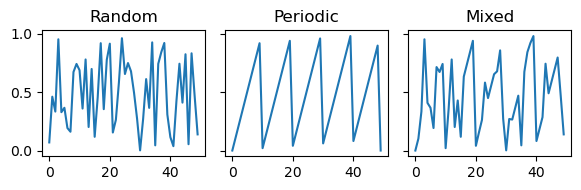

In [95]:
x_random = np.random.uniform(0, 1, 50)
x_periodic = (np.linspace(0, 5, 50))%1.0
x_mix = np.empty(shape=x_random.shape)

for i in range(x_random.shape[0]):
    if np.random.uniform(0,1) > 0.5:
        x_mix[i] = x_random[i]
    else:
        x_mix[i] = x_periodic[i]

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].plot(x_random)
axs[1].plot(x_periodic)
axs[2].plot(x_mix)
axs[0].set_title('Random')
axs[1].set_title('Periodic')
axs[2].set_title('Mixed')
fig.set_size_inches(6,2)
fig.tight_layout()
plt.show()

The stochasic model can now be put into use in a first test run. We are using the following parameter values:

$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7\\
L = 60
$$

Definitions in literature measure the period of infection in days and the expected lifespan in years. Here we set the former to one week and the latter to 60 years.

A time limit of 120 days is set for the simulation. Furthermore, to capture a broader picture of the behaviour of the system, 50 separate runs are simultaneously plotted using different random seeds. To align the time-grids of all plots and overcome the issue of inconsistent time-steps, the traced values are re-sampled using a quarter-day grid. This facilitates the visualisation of the error margin within the collection of runs.

In the following experiment the initial state comprises a single infected person versus the rest of the population being susceptible.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


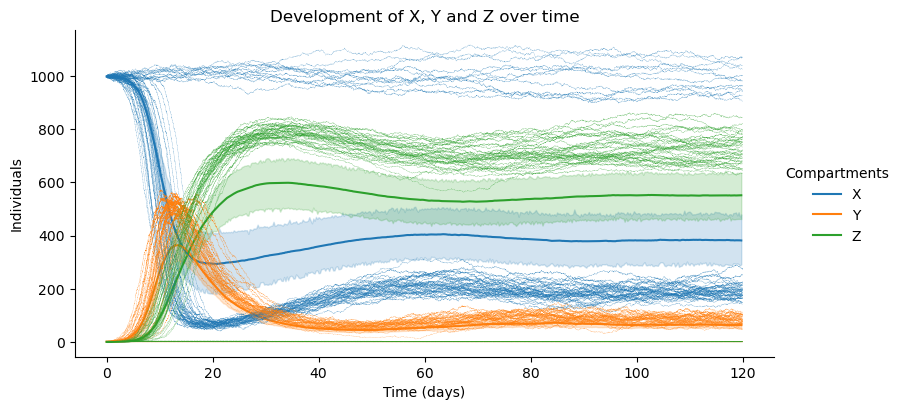

In [98]:
def plot_stochastic_model(maxtime, X_start, Y_start, Z_start, seed_max, title_add='', noise_lvl=1.0, phase_range=0.0, plot_det=False, **model_params):
    """Creates an instance of InfectionModelStochastic
    and plots the development of the X, Y and Z compartment over the predefined time.
    Includes an option to plot a corresponding deterministic model as a reference
    """

    # Range of random seeds
    seed_range = np.arange(0, seed_max, 1)

    # DataFrame for storing data from runs
    array_runs = np.array([[seed_range[0], 0, X_start, Y_start, Z_start]]).T
    array_runs_interp = array_runs[:]

    # Resample time in quarter-day intervals
    time_resample = np.arange(0, maxtime, 0.25)

    for s in seed_range:
        
        np.random.seed(s)

        #stochastic_SIR = InfectionModelStochastic(X_start, Y_start, Z_start, k=8, c=0.1, pinf=7, lifespan=16107.525)
        stochastic_SIR = InfectionModelStochastic(X_start, Y_start, Z_start,
                                                  k=model_params['k'], c=model_params['c'],
                                                  pinf=model_params['pinf'], lifespan=model_params['lifespan'],
                                                  beta=model_params['beta'], gamma=model_params['gamma'])

        time_track, X_track, Y_track, Z_track, _ = stochastic_SIR.iterate(maxtime, noise_lvl, phase_range)

        values_track = np.vstack([time_track, X_track, Y_track, Z_track])
        values_head = np.full([1,values_track.shape[1]], s)
        array_runs = np.append(array_runs, np.concatenate((values_head, values_track), axis=0), axis=1)

        # Interpolate (resample) values
        X_interp = np.interp(time_resample, time_track, X_track)
        Y_interp = np.interp(time_resample, time_track, Y_track)
        Z_interp = np.interp(time_resample, time_track, Z_track)
        values_interp = np.vstack([time_resample, X_interp, Y_interp, Z_interp])
        values_interp_head = np.full([1,values_interp.shape[1]], s)
        array_runs_interp = np.append(array_runs_interp, np.concatenate((values_interp_head, values_interp), axis=0), axis=1)

    print(f"R_0 = {stochastic_SIR.R0}")
    print(f"beta = {stochastic_SIR.beta}")
    print(f"gamma = {stochastic_SIR.gamma}")
    print(f"mu = {stochastic_SIR.mu}")

    # Construct DataFrames
    if plot_det:

        # Initialize and run deterministic model
        step = 10e-3
        deterministic_SIR = InfectionModelDeterministic(X_start, Y_start, Z_start,
                                                        k=model_params['k'], c=model_params['c'],
                                                        pinf=model_params['pinf'], lifespan=model_params['lifespan'],
                                                        beta=model_params['beta'], gamma=model_params['gamma'])
        values_track = np.vstack(deterministic_SIR.iterate(step, maxtime))
        df_runs = pd.DataFrame(values_track.T, columns=['time','$X_d$','$Y_d$','$Z_d$'])
        df_runs_melt = df_runs.melt('time', var_name='Compartments', value_name='vals')

    else:
        df_runs = pd.DataFrame(array_runs.T, columns=['seed','time','$X$','$Y$','$Z$'])
        df_runs_melt = df_runs.melt(['time','seed'], var_name='Compartments', value_name='vals')
    
    df_runs_interp = pd.DataFrame(array_runs_interp.T, columns=['seed','time','X','Y','Z'])
    df_runs_interp_melt = df_runs_interp.melt(['time','seed'], var_name='Compartments', value_name='vals')

    # Plot aggregation of stochastic runs (mean + sd)
    sns.relplot(df_runs_interp_melt, x='time', y='vals', kind='line', hue='Compartments', height=4, aspect=2.)

    # Plot either separate stochastic runs or deterministic run
    if plot_det: sns.lineplot(df_runs_melt, x='time', y='vals', hue='Compartments', palette='Set2', legend=False, dashes=[5,5])
    else: sns.lineplot(df_runs_melt, x='time', y='vals', hue='Compartments', style='seed', legend=False, linewidth=0.2)
    plt.xlabel('Time (days)')
    plt.ylabel('Individuals')
    plt.title('Development of X, Y and Z over time'+title_add)
    plt.show()


# Global simulation parameters
maxtime = 120 # days
X_start = 999
Y_start = 1
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None, mu=None)

Several observations can be made:
- Generally, consistent equilibria are present, with the compartment numbers oscillating around these;
- The distributions get skewed by occasional extinctions of the disease;
- The timing of the peak of infection exhibits some variation.

In order to prevent extinction of the pathogen before the infectious outbreak, one can examine a situation with more than one initial infected - in this case one percent of the population or 10 people. Additionally, the plot will be overlaid with the results from the deterministic counterpart of the model.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


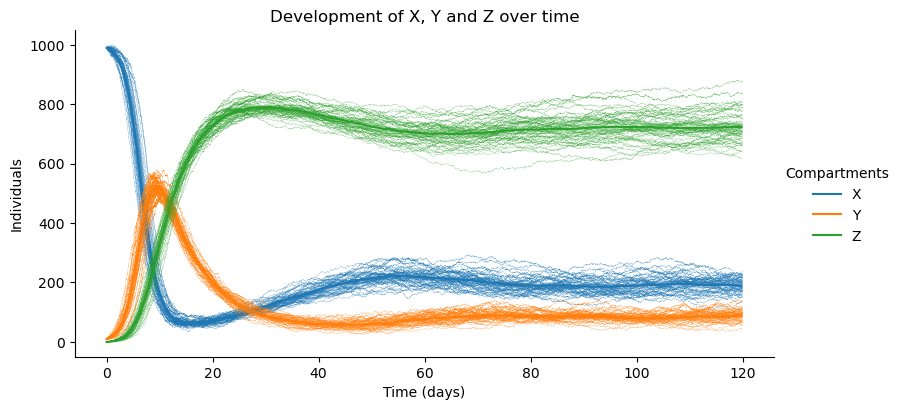

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


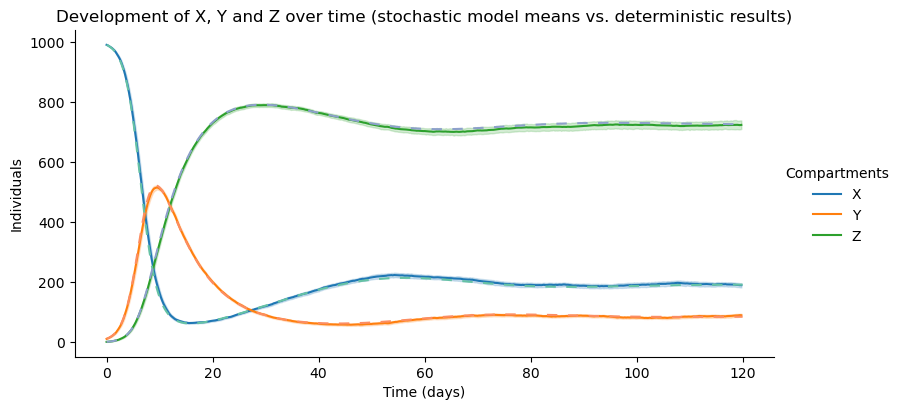

In [92]:
# Global simulation parameters
maxtime = 120 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, plot_det=False,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)
plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (stochastic model means vs. deterministic results)', plot_det=True,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

Noticeably, this narrows down the standard deviation of the 50 runs and presents more aligned trajectories.

Next, the effect of the noise control is explored by testing three configurations of the noise control parameters:
- an equal mix of the deterministic periodic pattern and the stochastic behaviour (`noise_lvl = 0.5`) and a small range for the random phase offset of the periodic pattern (`phase_range = 0.1`);
- a fully deterministic pattern (`noise_lvl = 0.0`) with a slight phase offset (`phase_range = 0.1`).
- a fully deterministic pattern (`noise_lvl = 0.0`) with a maximum phase offset range (`phase_range = 1.0`). The smoothing caused by the averaging of the time-displaced patterns is compared to the result curves of the deterministic model.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


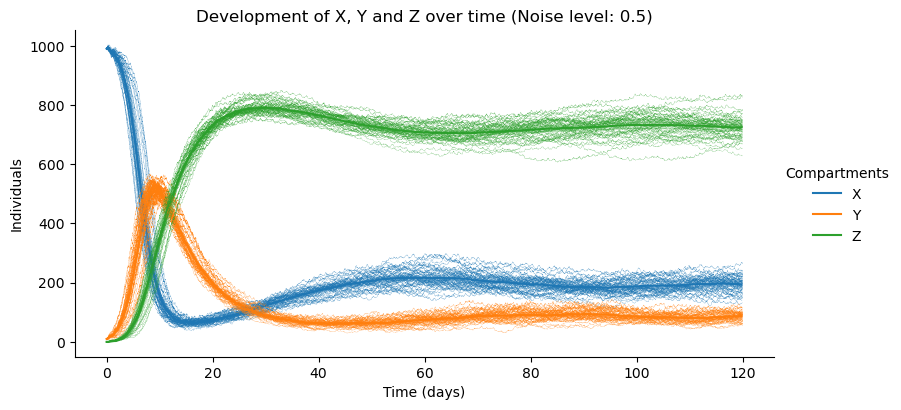

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


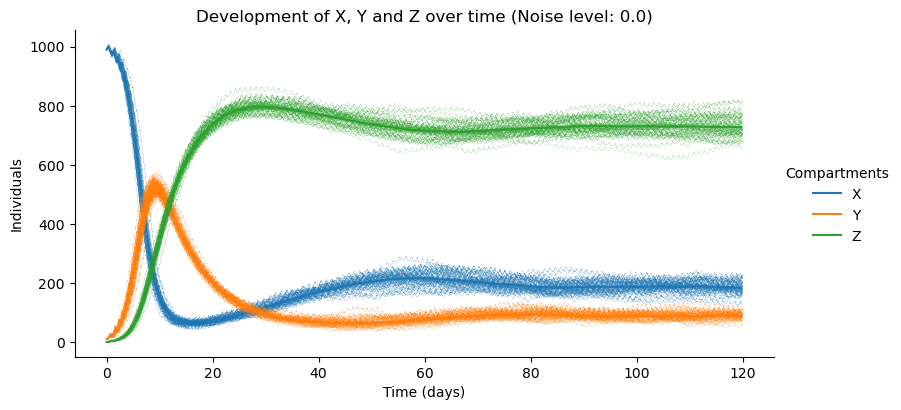

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


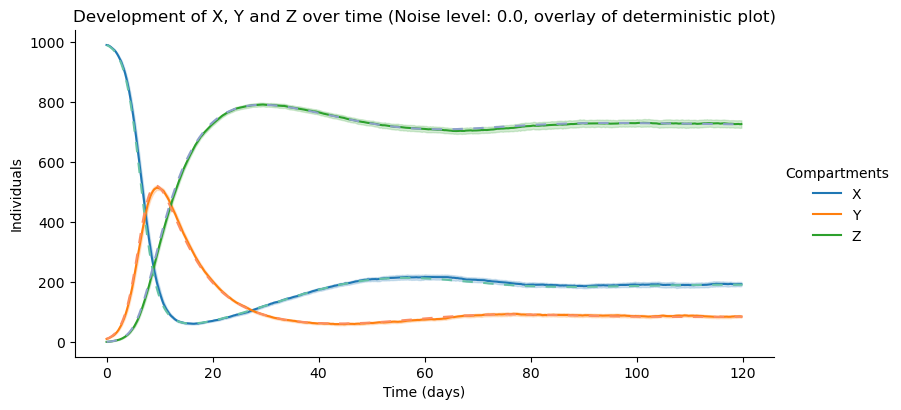

In [103]:
# Global simulation parameters
maxtime = 120 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.5)', noise_lvl=0.5, phase_range=0.1,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.0)', noise_lvl=0.0, phase_range=0.1, plot_det=False,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.0, overlay of deterministic plot)', noise_lvl=0.0, phase_range=1.0, plot_det=True,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

Observing the separate runs of the stochastic model with completely removed noise (up to the phase offset of the periodic pattern) reveals the sawtooth-like fluctuations resulting from the fact that only one event can be executed within a discrete time moment.

The overlay of the results from the deterministic model shows significant alignment with the means of the stochastic model at all introduced levels of noise.

### 1.3. Parameter Influence on Stochastic Behaviour

The following parameters are inspected for their effect on the variance between runs, the co-variance between susceptible and infected, the stochastic resonance around the equilibrium and the extinction events:
- the population size;
- the initial number of infected individuals $Y_0$;
- the infection rate $\beta$;
- the recovery rate $\gamma$;
- the demographic rate $\mu$ via the expected lifespan.

The previously tested configuration of parameters is used as a baseline for the default parameter values. Only the parameter of interest is incrementally varied. To take into account the dimension of time in the statistical analysis, a simulation period of one year is split into four quarter-year compartments so that the average variance and covariance per compartment can be analysed separately. The setup per parameter value is run 100 times to capture different outcomes. Again, the simulation results are re-sampled by interpolation to arrays with a common size.

The method takes two Python dictionaries - one with the ranges of parameter values that are to be explored and one with the default parameter values for their fixed state.

**WARNING: The code below executes many simulations, the calculations may take a very long time!**

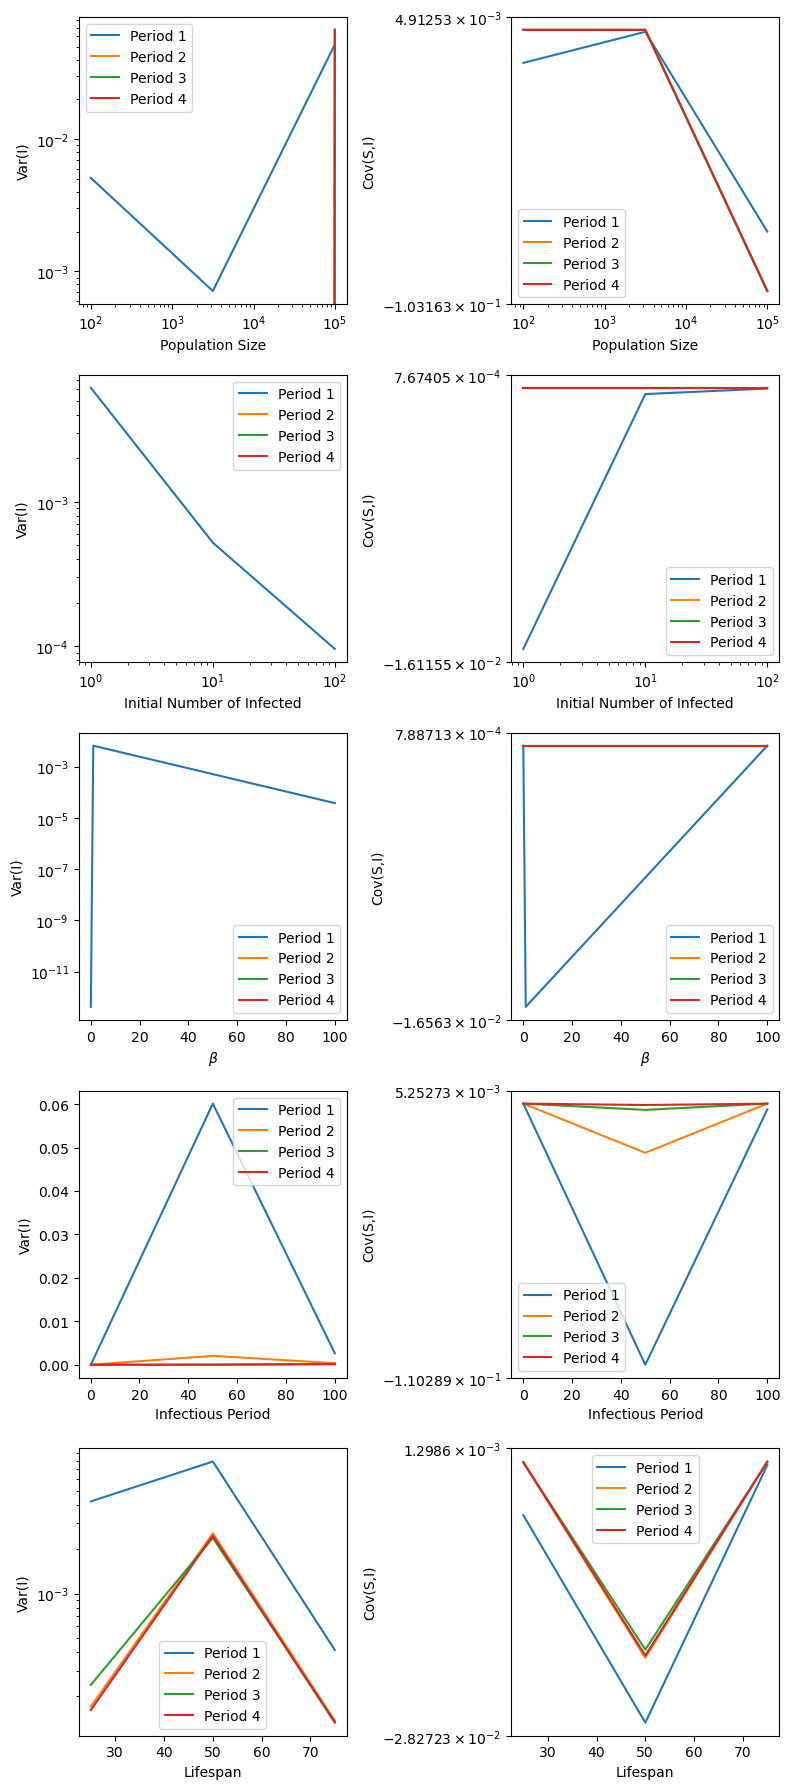

In [79]:
def analyse_var_cov(maxtime, n_runs, n_time_periods, n_periods_plot, *params_default_and_analysed):
    """Initialise and run multiple realisations of stochastic infection model with given ranges of parameters.
    Plot the resulting analysis of variances and covariances in a grid.
    The args  *params contains a list of two dictionaries containing (1) the range of values to be analysed and
    (2) the default parameter values
    """

    params = params_default_and_analysed[0]
    defaults = params_default_and_analysed[1]

    param_keys = list(params.keys())

    # Resample time in quarter-day intervals
    time_resample = np.arange(0, maxtime, 0.25)

    ax_width = 4
    fig, axs = plt.subplots(len(params), 2)
    fig.set_size_inches(ax_width*2, len(params)*0.9*ax_width)

    param_key_ct = 0
    for param in params:

        S_var_period_means = np.empty((params[param].shape[0], n_time_periods))
        I_var_period_means = np.empty((params[param].shape[0], n_time_periods))
        SI_cov_period_means = np.empty((params[param].shape[0], n_time_periods))

        param_ct = 0
        for param_value in params[param]:

            S_grid = np.empty((n_runs, time_resample.shape[0]))
            I_grid = np.empty((n_runs, time_resample.shape[0]))

            # Set model parameters
            if param == 'Population Size':
                n_pop = param_value
                scales = ['log', 'log', 'symlog']
            else:
                n_pop = defaults['pop_def']
            if param == 'Initial Number of Infected':
                Y_start = param_value
                scales = ['log', 'log', 'symlog']
            else:
                Y_start = defaults['Y_start_def']
            if param == 'beta':
                beta = param_value
                scales = ['linear', 'log', 'symlog']
            else:
                beta = None
            if param == 'gamma':
                gamma = param_value
                scales = ['linear', 'log', 'symlog']
            else:
                gamma = None
            if param == 'Infectious Period':
                pinf = param_value
                scales = ['linear', 'linear', 'symlog']
            else:
                pinf = defaults['pinf_def']
            if param == 'Lifespan':
                lifespan = param_value
                scales = ['linear', 'log', 'symlog']
            else:
                lifespan = defaults['lspan_def']
            
            # Perform multiple realizations of stochastic model
            for s in range(n_runs):
                
                np.random.seed(s)

                # Create model instance
                stochastic_SIR = InfectionModelStochastic(n_pop - Y_start, Y_start, 0,
                                                          k=defaults['k_def'], c=defaults['c_def'], pinf=pinf,
                                                          beta=beta, gamma=gamma, lifespan=lifespan)

                # Run model
                time_track, X_track, Y_track, Z_track, N_track = stochastic_SIR.iterate(maxtime)
                # print(f"Final population size: {stochastic_SIR.N}")
                
                # Normalize X, Y and Z to S, I and R
                S_track = [X_track[i] / N_track[i] for i in range(len(N_track))]
                I_track = [Y_track[i] / N_track[i] for i in range(len(N_track))]
                
                # Interpolate (resample) values
                S_interp = np.interp(time_resample, time_track, S_track)
                I_interp = np.interp(time_resample, time_track, I_track)

                S_grid[s] = S_interp
                I_grid[s] = I_interp

            S_variances = np.var(S_grid, axis=0)
            I_variances = np.var(I_grid, axis=0)
            S_means = np.mean(S_grid, axis=0)
            I_means = np.mean(I_grid, axis=0)
            SI_covariances = np.mean((S_grid - S_means)*(I_grid - I_means), axis=0)

            # Split in time compartments and calculate compartment means
            S_var_periods = np.split(S_variances, n_time_periods)
            I_var_periods = np.split(I_variances, n_time_periods)
            SI_cov_periods = np.split(SI_covariances, n_time_periods)
            S_var_period_means[param_ct] = np.mean(I_var_periods, axis=1)
            I_var_period_means[param_ct] = np.mean(I_var_periods, axis=1)
            SI_cov_period_means[param_ct] = np.mean(SI_cov_periods, axis=1)

            param_ct += 1

        if param_keys[param_key_ct] == 'beta' or param_keys[param_key_ct] == 'gamma':
            xlabel = "$\\" + param_keys[param_key_ct] + "$"
        else :
            xlabel = param_keys[param_key_ct]
        
        for i in range(n_periods_plot):
            axs[param_key_ct][0].plot(params[param], I_var_period_means.T[i], label=f"Period {i+1}")
            axs[param_key_ct][1].plot(params[param], SI_cov_period_means.T[i], label=f"Period {i+1}")
            

        axs[param_key_ct][0].set_xlabel(xlabel)
        axs[param_key_ct][0].set_ylabel('Var(I)')
        axs[param_key_ct][0].set_xscale(scales[0])
        axs[param_key_ct][0].set_yscale(scales[1])
        axs[param_key_ct][0].legend()

        axs[param_key_ct][1].set_xlabel(xlabel)
        axs[param_key_ct][1].set_ylabel('Cov(S,I)')
        axs[param_key_ct][1].set_xscale(scales[0])
        axs[param_key_ct][1].set_yscale(scales[2])
        axs[param_key_ct][1].legend()

        # if param != 'Initial Number of Infected': axs[param_key_ct][1].set_ylim(top=0)

        param_key_ct += 1

    plt.tight_layout()

# Global simulation parameters
# maxtime = 1827 # days, equivalent to 5 years
maxtime = 364 # approx 1 year (divisible by 4)
n_runs = 100
n_param_samples = 50
n_time_periods = 4
n_periods_plot = 4

# Dictionary of parameter values
params = {
    'Population Size': np.geomspace(100, 100000, n_param_samples),
    'Initial Number of Infected': np.geomspace(1, 100, n_param_samples),
    'beta': np.geomspace(0.01, 100, n_param_samples),
    #'gamma': np.geomspace(0.01, 10, n_param_samples),
    'Infectious Period': np.linspace(0.1, 100, n_param_samples),
    'Lifespan': np.linspace(25, 75, n_param_samples)
}

defaults = {
    'pop_def': 1000,
    'Y_start_def': 1,
    'k_def': 8,
    'c_def': 0.1,
    'pinf_def': 7,
    'lspan_def': 60
}

analyse_var_cov(maxtime, n_runs, n_time_periods, n_periods_plot, params, defaults)

As an additional verification of these observations, the baseline configuration can be altered to produce an equilibrium state around a higher number of $Y$, with a demography-driven oscillatory behaviour of a more substantial amplitude. The default parameters are chosen as follows:

===================
$$A=\frac{1}{\mu(R_0-1)}$$
$$G=\frac{1}{\mu+\gamma}$$

$$\omega = \frac{1}{\sqrt{AG}}$$

===================

First, it is usefult to plot a typical outcome of the stochastic model with this parameter configuration and of its deterministic counterpart:

In [62]:
mu, gamma, b = symbols('mu gamma beta', real=True)

R0 = b/(gamma+mu)
a = 1/(mu*(R0-1))
g = 1/(mu+gamma)
omega = 1/sqrt(a*g)

i_equil = mu/b*(R0-1)
decay = -mu*R0/2

print(omega)
print(i_equil)

i_equil.subs(mu, 1/16107.525)
omega.subs(mu, 1/16107.525)

print(omega)
print(i_equil)

eqn1 = Eq(i_equil, 0.2)
eqn2 = Eq(omega, 1/90)
eqn3 = Eq(decay, -5)

print(eqn1)

# eqn1_subs = eqn1.subs(mu, 1/16107.525)
# eqn2_subs = eqn2.subs(mu, 1/16107.525)

solution = solve([eqn1, eqn2, eqn3], [b, gamma, mu], dict=True)

# eqn1_subs = eqn1.subs(mu, 1/180)
# eqn2_subs = eqn2.subs(mu, 1/180)

# solution = solve([eqn1_subs, eqn2_subs], [b, gamma], dict=True)

print(solution)

1/sqrt(1/(mu*(gamma + mu)*(beta/(gamma + mu) - 1)))
mu*(beta/(gamma + mu) - 1)/beta
1/sqrt(1/(mu*(gamma + mu)*(beta/(gamma + mu) - 1)))
mu*(beta/(gamma + mu) - 1)/beta
Eq(mu*(beta/(gamma + mu) - 1)/beta, 0.2)
[]


### 1.4. Stochastic Resonance and Transients



R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


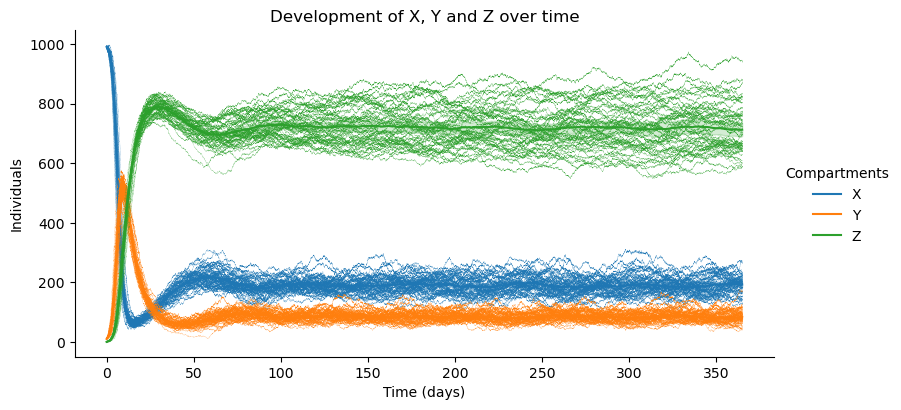

In [104]:
# Global simulation parameters
maxtime = 365.25 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, plot_det=False,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

### 1.5. Extinction Events and Critical Community Size

Stochastic models inherently precondition a chance of disease extinction, given sufficient time. Therefore, in order to be able to quantify the predisposition of the system to extinction, a mechanism for importing infected individuals into the population must be introduced.

In [18]:
a = np.array([[0, 0.1, 0.5, 0.6], [0, 0.05, 0.2, 0.8]])
b = np.array([[1, 0.9, 0.5, 0.4], [1, 0.8, 0.6, 0.1]])
print(np.cov(a, b, rowvar=True))
print(np.var(a, axis=0))

a_means = np.mean(a, axis=0)
b_means = np.mean(b, axis=0)
print(a_means)
print(a - a_means)
print(np.mean((a - a_means)*(b - b_means), axis=0))

[[ 0.08666667  0.09       -0.08666667 -0.10333333]
 [ 0.09        0.135625   -0.09       -0.13875   ]
 [-0.08666667 -0.09        0.08666667  0.10333333]
 [-0.10333333 -0.13875     0.10333333  0.14916667]]
[0.       0.000625 0.0225   0.01    ]
[0.    0.075 0.35  0.7  ]
[[ 0.     0.025  0.15  -0.1  ]
 [ 0.    -0.025 -0.15   0.1  ]]
[ 0.       0.00125 -0.0075  -0.015  ]
